# Example: Obtaining results from the eq and profiles objects

Here we will take a look at how to access different results stored (or calculated using methods) in the `eq` and `profiles` objects. 

To do this we first need to run a static forward simulation in the MAST-U-like tokamak using previously saved coil currents to generate our results. Of course, the same methods below can be applied after an inverse solve!

## Static forward simulation

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.
Forward static solve SUCCESS. Tolerance 9.43e-10 (vs. requested 1.00e-09) reached in 25/100 iterations.


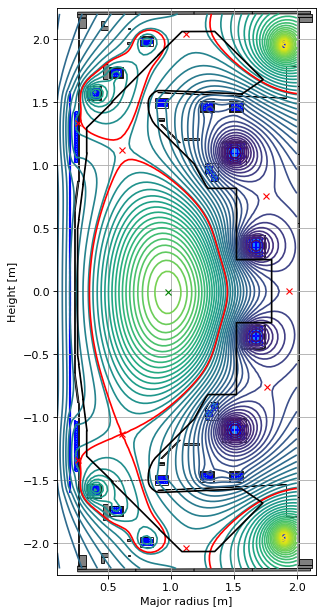

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

# initialise equilibrium object
from freegsnke import equilibrium_update
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)  

# initialise profile object
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,
    paxis=8.1e3,
    Ip=6.2e5,
    fvac=0.5,
    alpha_m=1.8,
    alpha_n=1.2
)

# initialise solver
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

# set coil currents
import pickle
with open('data/simple_diverted_currents_PaxisIp.pk', 'rb') as f:
    current_values = pickle.load(f)

for key in current_values.keys():
    eq.tokamak[key].current = current_values[key]
eq.tokamak["P6"].current += 100

# carry out forward solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=None, 
                     target_relative_tolerance=1e-9)

# plot the resulting equilbrium
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()

## Dashboard of results

It is worth playing around with the fields/methods in the `eq` and `profiles` objects yourself to see which quantities can be calculated from the plasma equilibrium using built-in functionality. Below, we provide a mini dashboard of different quantities and how to generate them. 

If there are certain quantites that you wish to be added that don't exist within FreeGSNKE at the moment, please do submit a feature request to the Github repository.

#### General equillibrium quantites
Here, we display a number of  used equilibrium quantites. 

In [2]:
# plasma quantities
print(rf"Plasma current: {eq.plasmaCurrent()} [A]")
print("---")
print(rf"Poloidal beta (definition 1): {eq.poloidalBeta1()}")
print(rf"Poloidal beta (definition 2): {eq.poloidalBeta2()}")
print(rf"Poloidal beta (definition 3): {eq.poloidalBeta3()}")
print(rf"Poloidal beta (definition 4): {eq.poloidalBeta4()}")
print("---")
print(rf"Toroidal beta (definition 1): {eq.toroidalBeta1()}")
print(rf"Toroidal beta (definition 2): {eq.toroidalBeta2()}")
print(rf"Toroidal beta (definition 3): {eq.toroidalBeta3()}")
print(rf"Toroidal beta (definition 4): {eq.toroidalBeta4()}")
print("---")
print(rf"Normalised total beta: {eq.normalised_total_Beta()}")
print("---")
print(fr"Plasma internal inductance (definition 1): {eq.internalInductance1()}")
print(fr"Plasma internal inductance (definition 2): {eq.internalInductance2()}")
print(fr"Plasma internal inductance (definition 3): {eq.internalInductance3()}")
print(fr"Plasma internal inductance (definition 4): {eq.internalInductance4()}")
print(fr"Plasma internal inductance (definition 5): {eq.internalInductance5()}")

Plasma current: 620000.0000000001 [A]
---
Dicrepancy between psi_func and plasma_psi detected. psi_func has been re-set.
Poloidal beta (definition 1): 0.1890953958985275
Poloidal beta (definition 2): 0.2734321996762325


c:\Users\user1\miniconda3\envs\freegsnke\lib\site-packages\freegs4e\critical.py:1045: UserWarning: Theta grid too close to X-point, shifting by half-step
  warnings.warn("Theta grid too close to X-point, shifting by half-step")


Poloidal beta (definition 3): 103047.45204135324
Poloidal beta (definition 4): 0.1876391055465581
---
Toroidal beta (definition 1): 0.010902215801992535
Toroidal beta (definition 2): 0.014755548416773427
Toroidal beta (definition 3): 0.014000047148865677
Toroidal beta (definition 4): 0.018992621021463856
---
Normalised total beta: 0.010307917158210746
---
Plasma internal inductance (definition 1): 0.8005098148836879
Plasma internal inductance (definition 2): 0.9471689689439358
Plasma internal inductance (definition 3): 0.7170669914758815
Plasma internal inductance (definition 4): 0.6603848745628151
Plasma internal inductance (definition 5): 1.026705395880566


In [3]:
# plasma geometry quantities
print(rf"Minor radius: {eq.minorRadius()} [m]")
print("---")
print(rf"Magnetic axis location: {eq.magneticAxis()[0:2]} [m]")
print(rf"Geometric axis location: {eq.geometricAxis()} [m]")
print(rf"Shafranov shift: {eq.shafranov_shift()} [m]")
print(rf"Inner and outer mipdplane (Z=0) radii: {eq.innerOuterSeparatrix(Z=0)} [m]")
print(rf"Inner and outer mipdplane (Z=0) radii (alternative): {eq.innerOuterSeparatrix2(Z=0)} [m]")

print("---")
print(rf"LCFS circumference: {eq.separatrix_length()} [m]")
print(rf"LCFS area: {eq.separatrix_area()} [m^2]")
print(rf"Plasma volume: {eq.plasmaVolume()} [m^3]")

print("---")
print(rf"Aspect ratio: {eq.aspectRatio()}")

print("---")
print(rf"Geometric elongation: {eq.geometricElongation()}")
print(rf"Geometric elongation (upper): {eq.geometricElongation_upper()}")
print(rf"Geometric elongation (lower): {eq.geometricElongation_lower()}")
print(rf"Effective elongation: {eq.effectiveElongation()}")

print("---")
print(rf"Triangularity: {eq.triangularity()}")
print(rf"Triangularity (upper): {eq.triangularity_upper()}")
print(rf"Triangularity (lower): {eq.triangularity_lower()}")

print("---")
s_uo, s_ui, s_lo, s_li = eq.squareness()
print(rf"Squareness (upper outer): {s_uo}")
print(rf"Squareness (upper inner): {s_ui}")
print(rf"Squareness (lower outer): {s_lo}")
print(rf"Squareness (lower inner): {s_li}")

print("---")
L = eq.closest_wall_point()
print(rf"Point on wall that is closest to the LCFS: {L[0]} [m]")
print(rf"Corresponding distance from point to LCFS: {L[1]} [m]")

print("---")
print(rf"Is this a limited plasma?: {eq.flag_limiter}")
print(rf"Does the core plasma boundary intersect the wall?: {eq.intersectsWall()}")



Minor radius: 0.5470871953957378 [m]
---
Magnetic axis location: [ 0.97937857 -0.0095354 ] [m]
Geometric axis location: [ 0.90196146 -0.04217312] [m]
Shafranov shift: [0.0774171  0.03263771] [m]
Inner and outer mipdplane (Z=0) radii: (0.3545597661930289, 1.4491897473681123) [m]
Inner and outer mipdplane (Z=0) radii (alternative): [(1.4490215798530333, 0.0), (0.35491018588573736, 0.0)] [m]
---
LCFS circumference: 5.1778084976530625 [m]
LCFS area: 1.7018746654135466 [m^2]
Plasma volume: 9.196477949016394 [m^3]
---
Aspect ratio: 1.6486612552710715
---
Geometric elongation: 1.985458739815225
Geometric elongation (upper): 1.9183095494015219
Geometric elongation (lower): 2.052607930228928
Effective elongation: 1.7258009763000515
---
Triangularity: 0.44793950837384866
Triangularity (upper): 0.3925642233070125
Triangularity (lower): 0.5033147934406847
---
Squareness (upper outer): -0.12269282227169809
Squareness (upper inner): -0.14854078813549307
Squareness (lower outer): -0.16091955797101454

In [4]:
print(fr"Poloidal flux on magnetic axis: {eq.psi_axis} [Webers/2\pi]")
print(fr"Poloidal flux on plasma boundary: {eq.psi_bndry} [Webers/2\pi]")

Poloidal flux on magnetic axis: 0.09876285204702509 [Webers/2\pi]
Poloidal flux on plasma boundary: 0.030619030842260267 [Webers/2\pi]


In [5]:
# extract the plasma core boundary (specify the number of points you want)
eq.separatrix(ntheta=20) 

array([[ 1.10671294,  0.79442218],
       [ 1.2809486 ,  0.5823291 ],
       [ 1.3617578 ,  0.37284383],
       [ 1.40935012,  0.20954605],
       [ 1.44419609,  0.06408446],
       [ 1.44250903, -0.08288806],
       [ 1.40719239, -0.22751743],
       [ 1.36177538, -0.39193222],
       [ 1.28048043, -0.60048107],
       [ 1.10624481, -0.81053732],
       [ 0.8173704 , -1.03241473],
       [ 0.52497953, -0.90134372],
       [ 0.4225874 , -0.56632657],
       [ 0.37486955, -0.31754813],
       [ 0.35681776, -0.10813935],
       [ 0.35704674,  0.08903227],
       [ 0.37568437,  0.29806216],
       [ 0.42466581,  0.54517735],
       [ 0.53253301,  0.86744839],
       [ 0.81924694,  1.00149592]])

In [6]:
# extract the X points (R, Z, psi)
eq.xpt

array([[ 0.61363478, -1.1334309 ,  0.03061903],
       [ 0.26698938, -1.33623775,  0.0304082 ],
       [ 0.26717743,  1.33797054,  0.03032373],
       [ 0.61382251,  1.11825669,  0.0299942 ],
       [ 1.12143555, -2.03914279,  0.02778671],
       [ 1.12109582,  2.04053967,  0.02763305],
       [ 1.76145526, -0.75828253, -0.0200721 ],
       [ 1.93667282, -0.00250579, -0.02042508],
       [ 1.75902578,  0.75861657, -0.02049007]])

In [7]:
# extract the strike points where the separatric intersects the wall, if any (R, Z)
eq.strikepoints()

array([[ 1.31287888, -2.06531994],
       [ 1.70977704, -1.66718575],
       [ 1.71420686,  1.66623653],
       [ 1.31968103,  2.06030489],
       [ 0.95293113, -1.93330548],
       [ 0.332797  , -1.26717015],
       [ 0.94348761,  1.91641072],
       [ 0.332797  ,  1.27717299]])

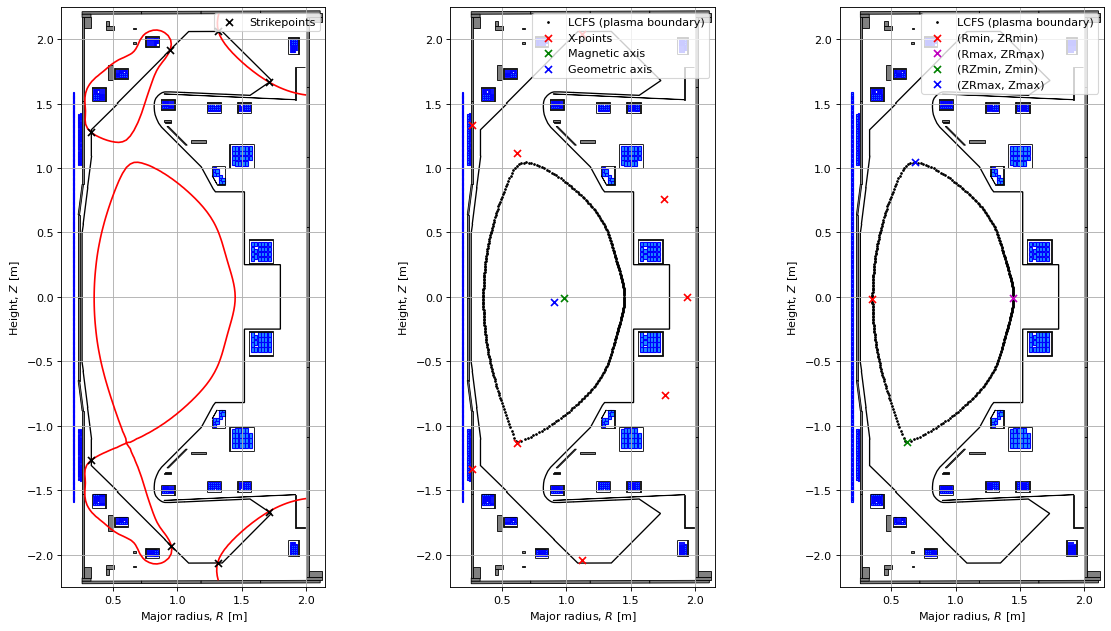

In [8]:
# here we plot some of the features above on different axes to show where they are located (see code documentation for more details)

sep = eq.separatrix(ntheta=360)
strikes = eq.strikepoints()

fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.25)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], linestyles='solid', colors='r') #, label="Separatrix")
ax1.scatter(strikes[:,0], strikes[:,1], color='k', marker='x', s=40, zorder=2, label="Strikepoints")
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
ax1.legend(loc="upper right")





ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax2.scatter(sep[:,0], sep[:,1], color='k', marker='o', s=2, zorder=2, label="LCFS (plasma boundary)")
ax2.scatter(eq.xpt[:,0], eq.xpt[:,1], color='r', marker='x', s=40, zorder=2, label="X-points")
ax2.scatter(eq.magneticAxis()[0], eq.magneticAxis()[1], color='g', marker='x', s=40, zorder=2, label="Magnetic axis")
ax2.scatter(eq.geometricAxis()[0], eq.geometricAxis()[1], color='b', marker='x', s=40, zorder=2, label="Geometric axis")
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
ax2.legend(loc="upper right")





ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
ax3.scatter(sep[:,0], sep[:,1], color='k', marker='o', s=2, zorder=2, label="LCFS (plasma boundary)")
ax3.scatter(eq._sep_Rmin, eq._sep_ZRmin, color='r', marker='x', s=40, zorder=2, label="(Rmin, ZRmin)")
ax3.scatter(eq._sep_Rmax, eq._sep_ZRmax, color='m', marker='x', s=40, zorder=2, label="(Rmax, ZRmax)")
ax3.scatter(eq._sep_RZmin, eq._sep_Zmin, color='g', marker='x', s=40, zorder=2, label="(RZmin, Zmin)")
ax3.scatter(eq._sep_RZmax, eq._sep_Zmax, color='b', marker='x', s=40, zorder=2, label="(ZRmax, Zmax)")
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
ax3.legend(loc="upper right")

plt.tight_layout()

Here we visualise the dr sep quantities.

These two distances are defined as the radial separation (on the inboard and outboard sides) at the vertical position `Z_level` between flux surfaces passing through the lower and upper X-points. The default `Z_level` value is at the geometric axis (i.e. `eq.Zgeometric()`), however, here we have chosen the midplance (at $Z=0$).

In [9]:
dr_seps = eq.dr_sep(Z_level=0)

print(f"dr_sep_in = {dr_seps[0]} [m].")
print(f"dr_sep_out = {dr_seps[1]} [m].")

dr_sep_in = -0.001972439841052942 [m].
dr_sep_out = 0.0009407156121290505 [m].


In the plot below, dr_sep_in is the difference between the radial position of the blue and the red flux surfaces at $Z=0$. 

Similarly, dr_sep_out is the difference between the radial position of the red and the blue flux surfaces at $Z=0$.

Text(0.5, 1.0, 'Outboard side: dr_sep_out')

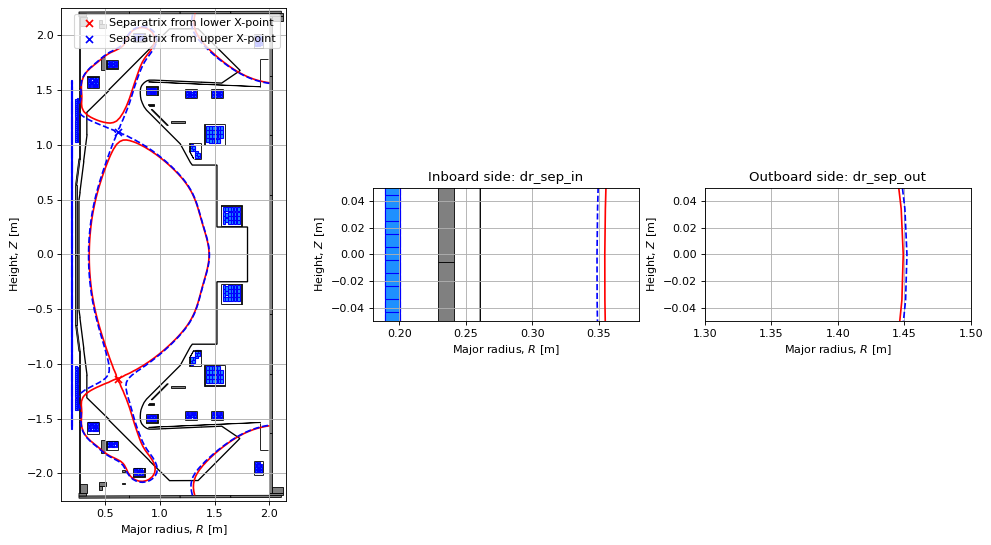

In [10]:
import shapely as sh

# visualising these quantities
psi_bndry = eq.psi_bndry
xpts = eq.xpt

# define your polygon (example)
polygon = sh.Polygon(np.array([eq.tokamak.wall.R, eq.tokamak.wall.Z]).T)

# vectorized-ish approach: boolean mask for points inside
mask = np.array([polygon.contains(sh.Point(x, y)) for x, y in xpts[:,0:2]])

# select points inside as a NumPy array
xpts_inside_wall = xpts[mask,:]

# get indices of the two cloest to magnetic axis 
closest_xpts_idxs = np.argsort(np.linalg.norm(xpts_inside_wall[:,0:2] - eq.opt[0,0:2], axis=1))
closest_xpts_sorted = xpts_inside_wall[closest_xpts_idxs[0:2],:]

# plot the flux contours for the values of psi_boundary at each X-point
fig1, axes = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.25)  # adjust the horizontal space between subplots

axes[0].grid(True, which='both')
eq.tokamak.plot(axis=axes[0],show=False)
axes[0].fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
axes[0].contour(eq.R, eq.Z, eq.psi(), levels=[closest_xpts_sorted[0, 2]], linestyles='solid', colors='r')
axes[0].contour(eq.R, eq.Z, eq.psi(), levels=[closest_xpts_sorted[1, 2]], linestyles='dashed', colors='b')
axes[0].scatter(closest_xpts_sorted[0,0], closest_xpts_sorted[0,1], color='r', marker='x', s=40, zorder=2, label="Separatrix from lower X-point")
axes[0].scatter(closest_xpts_sorted[1,0], closest_xpts_sorted[1,1], color='b', marker='x', s=40, zorder=2, label="Separatrix from upper X-point")
axes[0].set_aspect('equal')
axes[0].set_xlim(0.1, 2.15)
axes[0].set_ylim(-2.25, 2.25)
axes[0].set_xlabel(r'Major radius, $R$ [m]')
axes[0].set_ylabel(r'Height, $Z$ [m]')
axes[0].legend(loc="upper right")


axes[1].grid(True, which='both')
eq.tokamak.plot(axis=axes[1],show=False)
axes[1].fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
axes[1].contour(eq.R, eq.Z, eq.psi(), levels=[closest_xpts_sorted[0, 2]], linestyles='solid', colors='r')
axes[1].contour(eq.R, eq.Z, eq.psi(), levels=[closest_xpts_sorted[1, 2]], linestyles='dashed', colors='b')
axes[1].scatter(closest_xpts_sorted[0,0], closest_xpts_sorted[0,1], color='r', marker='x', s=40, zorder=2, label="Separatrix from lower X-point")
axes[1].scatter(closest_xpts_sorted[1,0], closest_xpts_sorted[1,1], color='b', marker='x', s=40, zorder=2, label="Separatrix from upper X-point")
axes[1].set_aspect('equal')
axes[1].set_xlim(0.18, 0.38)
axes[1].set_ylim(-0.05, 0.05)
axes[1].set_xlabel(r'Major radius, $R$ [m]')
axes[1].set_ylabel(r'Height, $Z$ [m]')
axes[1].set_title("Inboard side: dr_sep_in")


axes[2].grid(True, which='both')
eq.tokamak.plot(axis=axes[2],show=False)
axes[2].fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)
axes[2].contour(eq.R, eq.Z, eq.psi(), levels=[closest_xpts_sorted[0, 2]], linestyles='solid', colors='r')
axes[2].contour(eq.R, eq.Z, eq.psi(), levels=[closest_xpts_sorted[1, 2]], linestyles='dashed', colors='b')
axes[2].scatter(closest_xpts_sorted[0,0], closest_xpts_sorted[0,1], color='r', marker='x', s=40, zorder=2, label="Separatrix from lower X-point")
axes[2].scatter(closest_xpts_sorted[1,0], closest_xpts_sorted[1,1], color='b', marker='x', s=40, zorder=2, label="Separatrix from upper X-point")
axes[2].set_aspect('equal')
axes[2].set_xlim(1.3, 1.5)
axes[2].set_ylim(-0.05, 0.05)
axes[2].set_xlabel(r'Major radius, $R$ [m]')
axes[2].set_ylabel(r'Height, $Z$ [m]')
axes[2].set_title("Outboard side: dr_sep_out")




#### Flux quantites
Here, we plot the total poloidal flux $\psi$ [Webers / $2\pi$] and its two components $\psi_p$ (the plasma flux) and $\psi_c$ (the coil flux): $\psi = \psi_p + \psi_c$. 

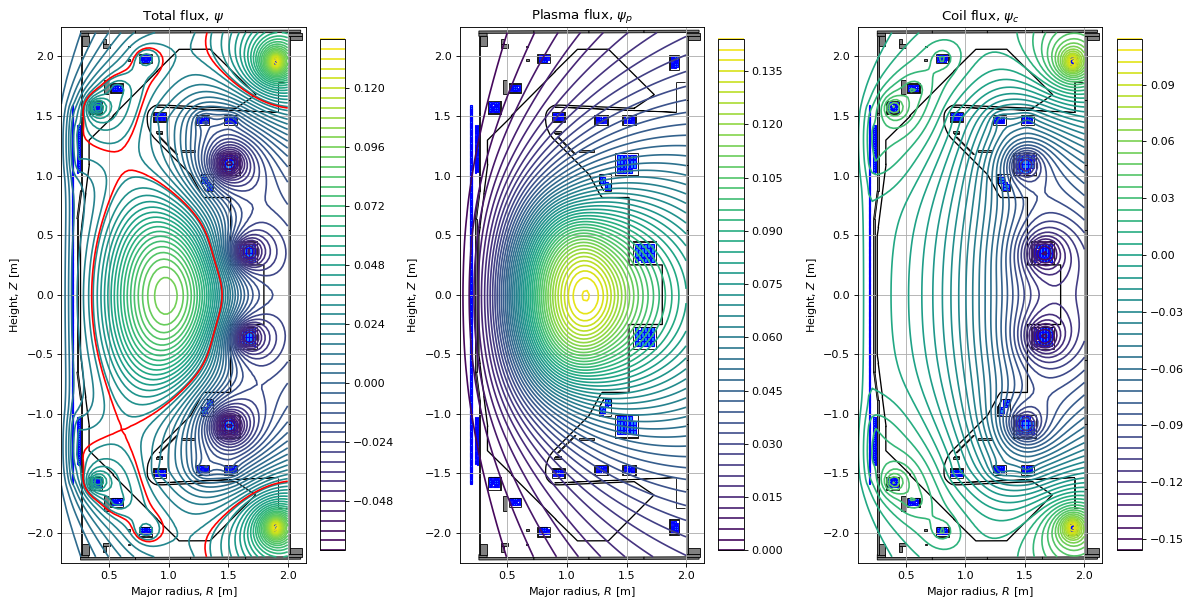

In [11]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.psi(), levels=50)                          # total psi
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')  # psi boundary contour
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"Total flux, $\psi$")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.plasma_psi, levels=50)                          # plasma psi
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"Plasma flux, $\psi_p$")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, eq.tokamak_psi, levels=50)                          # coil psi
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(r"Coil flux, $\psi_c$")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

We can also extract the flux produced by individual coils (or pasive structures) if required. We do this my using the pre-calculated Green's functions, the coil currents, multipliers, and polarities. 

In [12]:
currents = eq.tokamak.getCurrents()

# calculate the active/passive coil fluxes

psi_coils = dict()
for i, name in enumerate(currents.keys()):
    coil = eq.tokamak.coils_dict[name]
    scaling = coil["multiplier"]*coil["polarity"]
    greens_matrix = 0.0
    
    if type(eq._pgreen[name]) is dict:
        num_coils = len(eq._pgreen[name])
        for i, ind in enumerate(eq._pgreen[name]):
            greens_matrix += eq._pgreen[name][ind]*scaling[i*(len(scaling)//num_coils)]
    else:
        num_coils = 1
        greens_matrix = eq._pgreen[name]*scaling[0]

    psi_coils[name] = greens_matrix*currents[name]

Here, we plot a few of the fluxes from the coils. You can change the `name` parameters to visualise different coil fluxes.

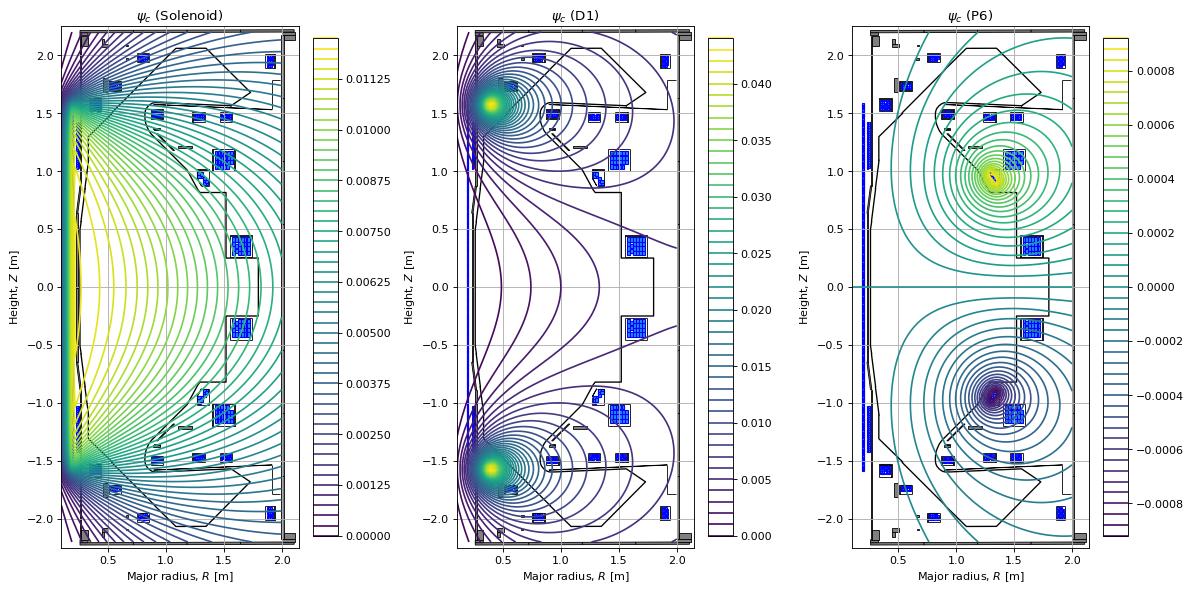

In [13]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

name = "Solenoid"
ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, psi_coils[name], levels=50)                         
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(rf"$\psi_c$ ({name})")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

name = "D1"
ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, psi_coils[name], levels=50)                         
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(rf"$\psi_c$ ({name})")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)

name = "P6"
ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, psi_coils[name], levels=50)                         
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(rf"$\psi_c$ ({name})")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

#### Magnetic fields

Here, we plot the different magnetic field components over the domain.

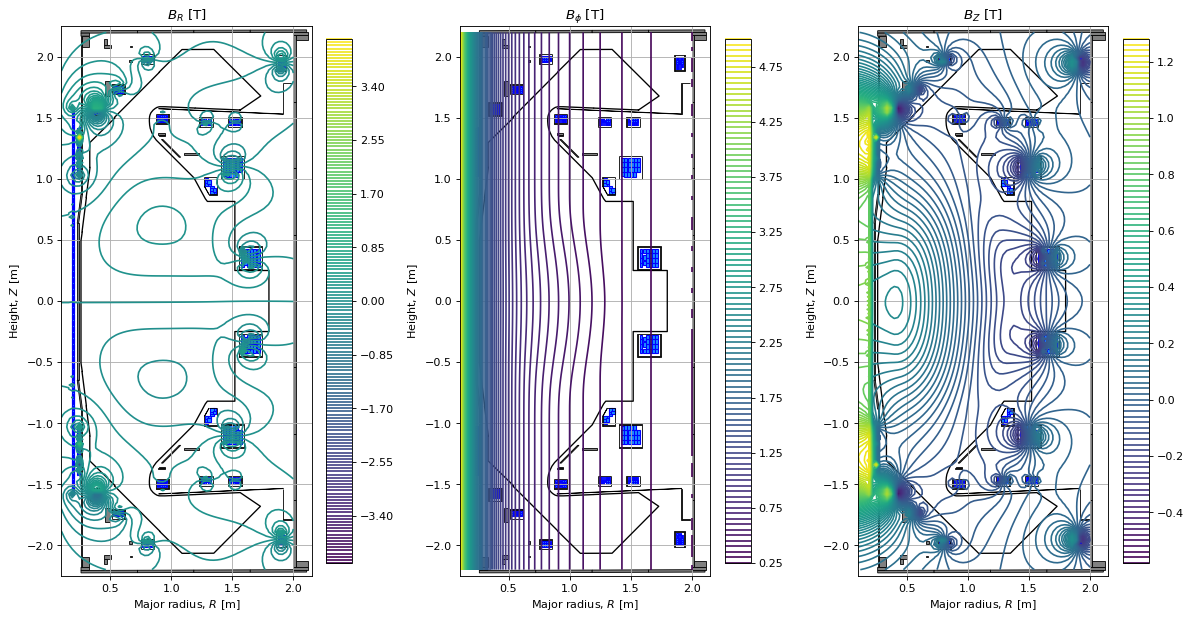

In [14]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.Br(eq.R, eq.Z), levels=200)                          
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.Btor(eq.R, eq.Z), levels=100)                          
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_{\phi}$ [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


ax3.grid(True, which='both')
eq.tokamak.plot(axis=ax3,show=False)
# ax3.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax3.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im3 = ax3.contour(eq.R, eq.Z, eq.Bz(eq.R, eq.Z), levels=100)                          
ax3.set_aspect('equal')
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)
ax3.set_title(r"$B_Z$ [T]")
ax3.set_xlabel(r'Major radius, $R$ [m]')
ax3.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im3, ax=ax3, fraction=0.09)


plt.tight_layout()

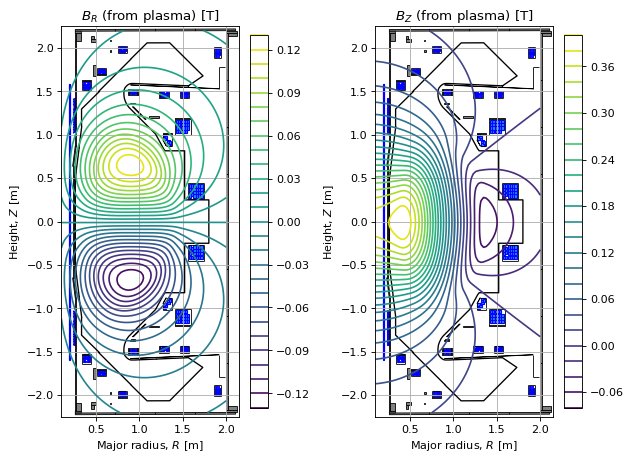

In [15]:
# this is just the contribution from the plasma
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.plasmaBr(eq.R, eq.Z), levels=30)                        
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ (from plasma) [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, eq.plasmaBz(eq.R, eq.Z), levels=30)                         
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_Z$ (from plasma) [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


plt.tight_layout()

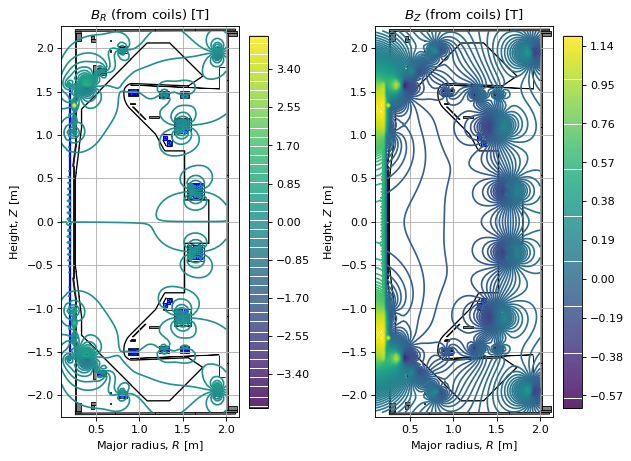

In [16]:
# this is just the contribution from the active coils

Br_actives = 0.0
Bz_actives = 0.0
for name in eq.tokamak.coils_list[0:12]:
    Br_actives += eq.tokamak[name].Br(eq.R, eq.Z)
    Bz_actives += eq.tokamak[name].Bz(eq.R, eq.Z)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, Br_actives, levels=200)                         
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_R$ (from coils) [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


ax2.grid(True, which='both')
eq.tokamak.plot(axis=ax2,show=False)
# ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im2 = ax2.contour(eq.R, eq.Z, Bz_actives, levels=200)                         
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_title(r"$B_Z$ (from coils) [T]")
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


plt.tight_layout()

In [17]:
# # this is just the contribution from the passive coils (note this is zero because there are no currents in the passives!)

# Br_passives = 0.0
# Bz_passives = 0.0
# for name in eq.tokamak.coils_list[12:]:
#     Br_passives += eq.tokamak[name].Br(eq.R, eq.Z)
#     Bz_passives += eq.tokamak[name].Bz(eq.R, eq.Z)
    
    
# fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8), dpi=80)
# plt.subplots_adjust(wspace=0.5)  # adjust the horizontal space between subplots

# ax1.grid(True, which='both')
# eq.tokamak.plot(axis=ax1,show=False)
# # ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
# ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
# im1 = ax1.contour(eq.R, eq.Z, Br_passives, levels=200)                         
# ax1.set_aspect('equal')
# ax1.set_xlim(0.1, 2.15)
# ax1.set_ylim(-2.25, 2.25)
# ax1.set_title(r"$B_R$ (from coils) [T]")
# ax1.set_xlabel(r'Major radius, $R$ [m]')
# ax1.set_ylabel(r'Height, $Z$ [m]')
# cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)


# ax2.grid(True, which='both')
# eq.tokamak.plot(axis=ax2,show=False)
# # ax2.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
# ax2.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
# im2 = ax2.contour(eq.R, eq.Z, Bz_passives, levels=200)                         
# ax2.set_aspect('equal')
# ax2.set_xlim(0.1, 2.15)
# ax2.set_ylim(-2.25, 2.25)
# ax2.set_title(r"$B_Z$ (from coils) [T]")
# ax2.set_xlabel(r'Major radius, $R$ [m]')
# ax2.set_ylabel(r'Height, $Z$ [m]')
# cbar = plt.colorbar(im2, ax=ax2, fraction=0.09)


# plt.tight_layout()

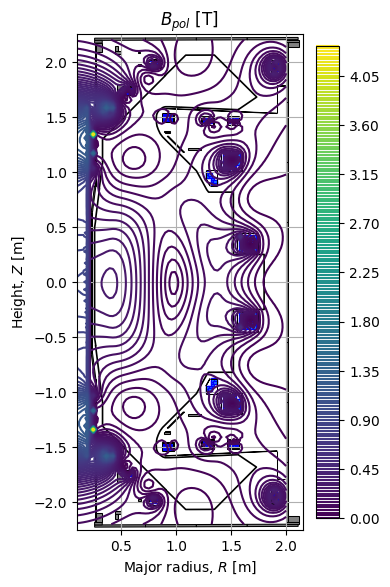

In [18]:
# total poloidal magnetic field

fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=100)

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
# ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contour(eq.R, eq.Z, eq.Bpol(eq.R, eq.Z), levels=200)                       
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"$B_{pol}$ [T]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

plt.tight_layout()

#### Coil currents

Here, we visualise the size of the currents in the poloidal field coils.

In [19]:
# listing the currents may not be that informative 
eq.tokamak.getCurrents()

{'Solenoid': 5000.0,
 'PX': 4667.6507393114125,
 'D1': 6036.412745092656,
 'D2': 1902.1330993358513,
 'D3': 1675.2655284624204,
 'Dp': -403.48697276555606,
 'D5': 3574.6194696528246,
 'D6': -1090.8033357495492,
 'D7': -568.2910042981962,
 'P4': -4561.171131065355,
 'P5': -4036.076708275128,
 'P6': 100.00016363020873,
 'vessel_1': 0.0,
 'vessel_2': 0.0,
 'vessel_3': 0.0,
 'vessel_4': 0.0,
 'vessel_5': 0.0,
 'vessel_6': 0.0,
 'vessel_7': 0.0,
 'vessel_8': 0.0,
 'vessel_9': 0.0,
 'vessel_10': 0.0,
 'vessel_11': 0.0,
 'vessel_12': 0.0,
 'vessel_13': 0.0,
 'vessel_14': 0.0,
 'vessel_15': 0.0,
 'vessel_16': 0.0,
 'vessel_17': 0.0,
 'vessel_18': 0.0,
 'vessel_19': 0.0,
 'vessel_20': 0.0,
 'vessel_21': 0.0,
 'vessel_22': 0.0,
 'centrecolumn_1': 0.0,
 'centrecolumn_2': 0.0,
 'centrecolumn_3': 0.0,
 'centrecolumn_4': 0.0,
 'centrecolumn_5': 0.0,
 'centrecolumn_6': 0.0,
 'centrecolumn_7': 0.0,
 'centrecolumn_8': 0.0,
 'centrecolumn_9': 0.0,
 'centrecolumn_10': 0.0,
 'colosseum_upper_1': 0.0,
 'co

You can play around with the colour schemes below to visualise how the current is distributed around the machine. Note here that there is no current in the passive structures but they can be included if present. 

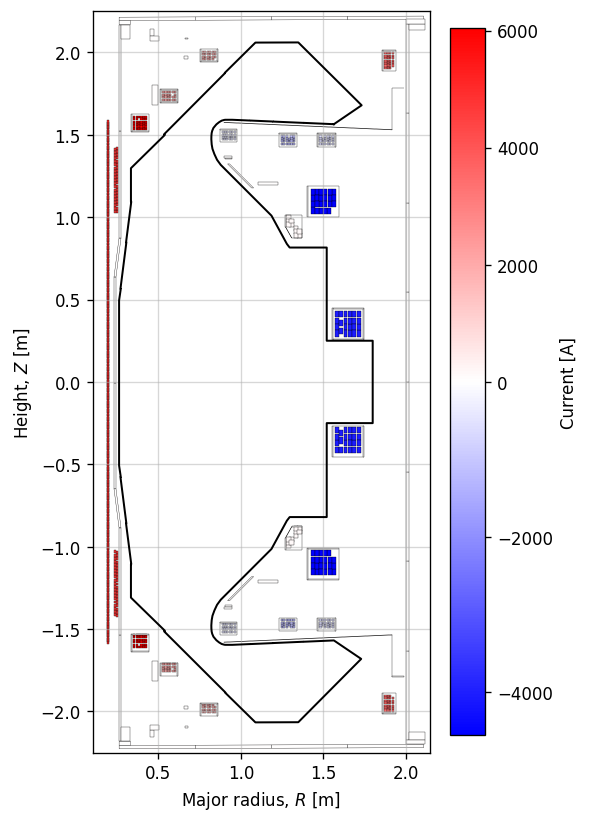

In [20]:
from matplotlib.patches import Rectangle, Polygon
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.cm as cm



# create colormap based on magnitude of currents
currents_array = []
for key in list(eq.tokamak.coils_dict.keys()):
    currents_array.append(eq.tokamak[key].current)

max_curr = np.max(np.abs(currents_array))
# norm = Normalize(vmin=-max_curr, vmax=max_curr) # alternative colorbar
norm = TwoSlopeNorm(vmin=np.min(currents_array), vcenter=0, vmax=np.max(currents_array))  
cmap = cm.bwr


# plot
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=120)
plt.tight_layout()
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')


for name in list(eq.tokamak.coils_dict.keys()):
    coil = eq.tokamak.coils_dict[name]
    current = eq.tokamak[name].current
    color = cmap(norm(current))  # map the current to a color
    
    # plot active coils (and currents)
    if coil["active"]:

        for i in range(0, len(coil["coords"][0,:])):
            patch = Rectangle(
                (coil["coords"][0,i] - coil["dR"] / 2, coil["coords"][1,i] - coil["dZ"] / 2),
                width=coil["dR"],
                height=coil["dZ"],
                facecolor=color,
                edgecolor='k',
                linewidth=0.2,
                )
            ax1.add_patch(patch)
    
    # plot passive structures (currents are zero here)        
    else:
        patch = Polygon(
            coil["vertices"].T, 
            facecolor=color, 
            edgecolor="k", 
            linewidth=0.2
        )
        ax1.add_patch(patch)


# add a colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 
cbar = fig1.colorbar(sm, ax=ax1, orientation='vertical', fraction=0.09)
cbar.set_label('Current [A]')

#### Forces on the coils

We can also extract the radial and vertical forces on the coils.

In [21]:
eq.printForces()

Forces on coils
Solenoid (circuit)
  Solenoid : R = 7973.49 kN , Z = -1.59 kN
PX (circuit)
  PX1 : R = 222.44 kN , Z = 12.47 kN
  PX2 : R = 223.33 kN , Z = -12.24 kN
D1 (circuit)
  D11 : R = 321.88 kN , Z = -52.88 kN
  D12 : R = 322.48 kN , Z = 53.19 kN
D2 (circuit)
  D21 : R = 9.86 kN , Z = -15.09 kN
  D22 : R = 9.96 kN , Z = 15.17 kN
D3 (circuit)
  D31 : R = 9.51 kN , Z = -5.01 kN
  D32 : R = 9.55 kN , Z = 5.07 kN
Dp (circuit)
  Dp1 : R = 3.91 kN , Z = -1.07 kN
  Dp2 : R = 3.91 kN , Z = 1.02 kN
D5 (circuit)
  D51 : R = 52.25 kN , Z = -2.83 kN
  D52 : R = 52.23 kN , Z = 2.90 kN
D6 (circuit)
  D61 : R = 11.86 kN , Z = -11.34 kN
  D62 : R = 11.90 kN , Z = 11.30 kN
D7 (circuit)
  D71 : R = -0.96 kN , Z = -9.32 kN
  D72 : R = -0.95 kN , Z = 9.31 kN
P4 (circuit)
  P41 : R = 87.17 kN , Z = 14.59 kN
  P42 : R = 86.91 kN , Z = -14.37 kN
P5 (circuit)
  P51 : R = 114.38 kN , Z = 16.99 kN
  P52 : R = 115.21 kN , Z = -16.50 kN
P6 (circuit)
  P61 : R = -0.93 kN , Z = -0.65 kN
  P62 : R = 0.97 kN ,

#### 1D plasma current density profiles (and others)
Here, we visualise the $p'$ and $FF'$ profiles used in our equilbirium solve. 

Text(0, 0.5, "$FF'(\\hat{\\psi})$")

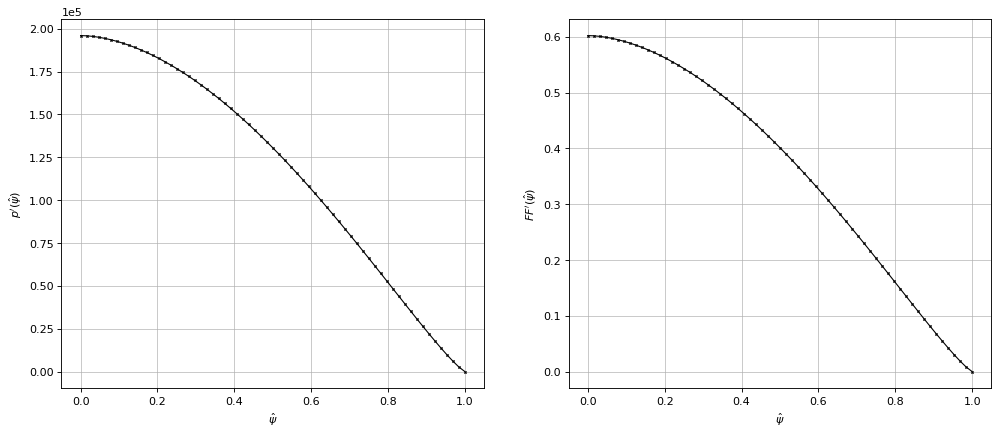

In [22]:
# plot the p' and FF' profiles

psi_n = eq.psiN_1D(N=65)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, profiles.pprime(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p'(\hat{\psi})$")
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, profiles.ffprime(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$FF'(\hat{\psi})$")

Text(0, 0.5, '$F(\\hat{\\psi})$')

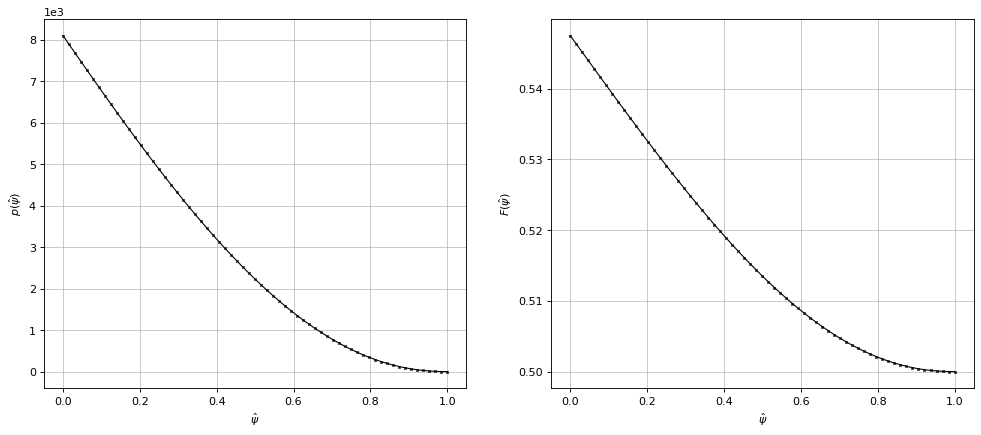

In [23]:
# plot the p and F profiles

psi_n = eq.psiN_1D(N=65)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, profiles.pressure(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p(\hat{\psi})$")
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, profiles.fpol(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$F(\hat{\psi})$")


Text(0, 0.5, '$F(\\hat{\\psi})$')

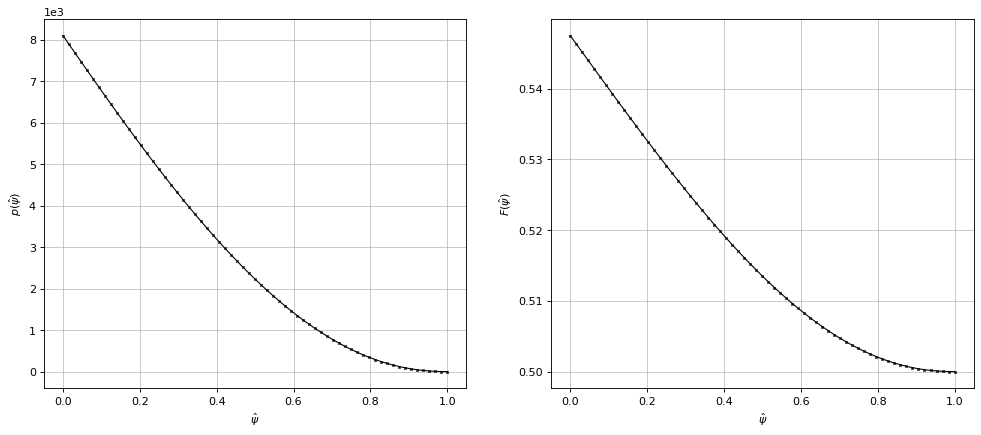

In [24]:
# plot the p and F profiles

psi_n = eq.psiN_1D(N=65)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, profiles.pressure(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$p(\hat{\psi})$")
ax1.ticklabel_format(axis='y', scilimits=(0,0))

ax2.grid(zorder=0, alpha=0.75)
ax2.plot(psi_n, profiles.fpol(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax2.set_xlabel(r'$\hat{\psi}$')
ax2.set_ylabel(r"$F(\hat{\psi})$")


Text(0, 0.5, '$q(\\hat{\\psi})$')

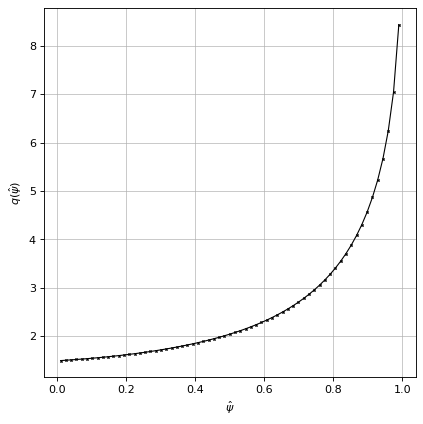

In [25]:
# plot q profile

psi_n = np.linspace(0.01,0.99,65)  # values of q at 0 and 1 can be problematic

fig1, ax1 = plt.subplots(1, 1, figsize=(6,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, eq.q(psi_n), color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$q(\hat{\psi})$")


#### Toroidal current density

Here, we visualise the toroidal current density inside the core of the plasma. 


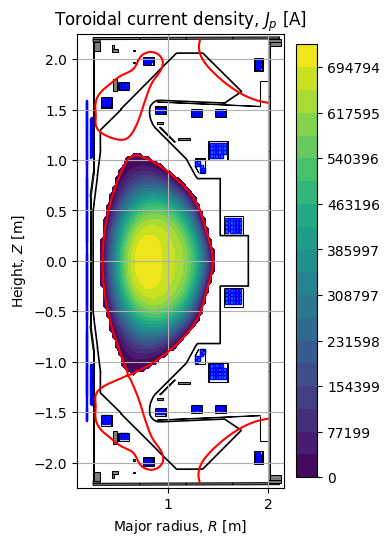

In [26]:
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=100)

ax1.grid(True, which='both')
eq.tokamak.plot(axis=ax1,show=False)
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")
im1 = ax1.contourf(eq.R, eq.Z, eq._profiles.jtor, levels=np.linspace(0.01, np.max( eq._profiles.jtor,), 20))                        
ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], colors='r')
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_title(r"Toroidal current density, $J_p$ [A]")
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
cbar = plt.colorbar(im1, ax=ax1, fraction=0.09)

plt.tight_layout()

### Masking arrays
There are a number of masking arrays that are built during the equilibrium solve that may be useful for plotting or other calculations you may carry out. 

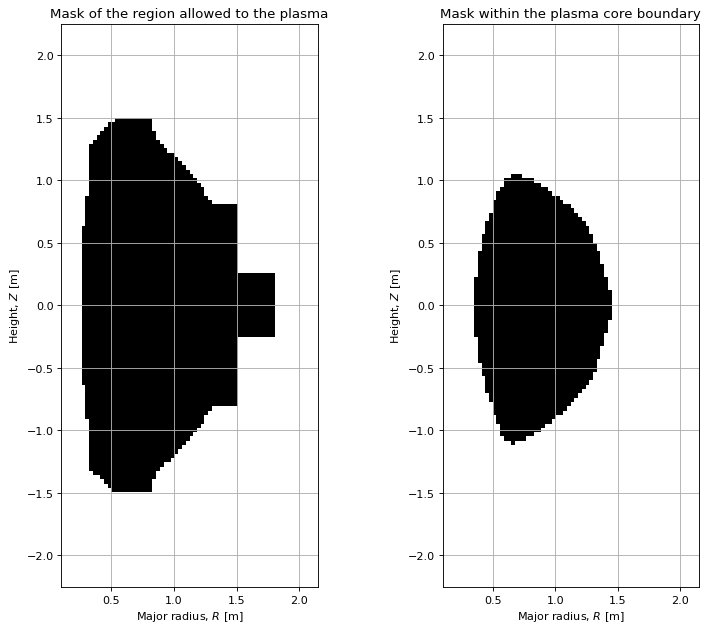

In [27]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), dpi=80)
plt.subplots_adjust(wspace=0.25)  # adjust the horizontal space between subplots

ax1.grid(True, which='both')
# eq.tokamak.plot(axis=ax1,show=False)
# ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor=None, zorder=0)
# ax1.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], linestyles='solid', colors='r') #, label="Separatrix")
ax1.pcolormesh(eq.R, eq.Z, eq.mask_inside_limiter, cmap="Greys")
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')
ax1.set_title("Mask of the region allowed to the plasma")


ax2.grid(True, which='both')
# eq.tokamak.plot(axis=ax2,show=False)
# ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor=None, zorder=0)
# ax2.contour(eq.R, eq.Z, eq.psi(), levels=[eq.psi_bndry], linestyles='solid', colors='r') #, label="Separatrix")
ax2.pcolormesh(eq.R, eq.Z, eq._profiles.diverted_core_mask, cmap="Greys")
ax2.set_aspect('equal')
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)
ax2.set_xlabel(r'Major radius, $R$ [m]')
ax2.set_ylabel(r'Height, $Z$ [m]')
ax2.set_title("Mask within the plasma core boundary")

plt.tight_layout()

### Flux averaged quantities

The `equilibrium` class provides a method to calculate the "flux averaged" value of a user-defined 2D scalar field $f(R,Z)$, using [line integrals](https://tutorial.math.lamar.edu/classes/calciii/LineIntegralsPtI.aspx), on a given (normalised) flux surface of $\psi_n$ (within the last closed flux surface). The flux average $\langle f \rangle$ is given by

$$
\langle f \rangle (\psi_n) = \frac{ \int_{C(\psi_n)} \frac{f(R,Z)}{B_{\text{pol}}(R,Z)}\, ds}{ \int_{C(\psi_n)} \frac{1}{B_{\text{pol}}(R,Z)} \, ds },
$$

where:
- $f(R,Z)$ = 2D scalar field function (e.g. the plasma current density function $J_p(R,Z)$).
- $\psi_n$ = value of normalised flux at which to evaluate line integrals.
- $C(\psi_n)$ = curve of $(R, Z)$ points satisfying $\psi_n = \text{const}$ (i.e. a flux contour).
- $B_{\text{pol}}(R,Z)$ = 2D scalar poloidal magnetic field function.
- $ds$ = the arc length element (where $ds = \sqrt{(dR/dl)^2 + (dZ/dl)^2} dl$ and $l \in [0,L]$ is a parameterised length going from the beginning to the end of the contour).

The definition of the flux average was taken from [Song et al. (2024)](https://www.mdpi.com/2571-6182/7/4/45).

Here we will calculate the flux averaged values of the plasma current density by first defining a function that returns the current density at arbitrary $(R,Z)$ locations. 

In [28]:
from scipy.interpolate import RectBivariateSpline

def f(R,Z):
    jtor = RectBivariateSpline(eq.R_1D, eq.Z_1D, eq._profiles.jtor)
    return jtor(R, Z, grid=False)

Next we can call the method in the equilibrium object and plot the results. Given the notation above, we note that $\psi_n$ and $\hat{\psi}$ are equivalent. 

In [29]:
# call the method
flux_averaged_jtor, psi_n = eq.flux_averaged_function(
    f=f,
    psi_n=np.linspace(0.0,1.0,101)
    )

Text(0, 0.5, '$\\langle J_p \\rangle (\\hat{\\psi})$')

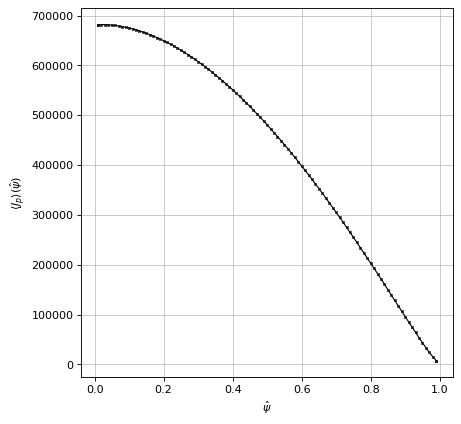

In [30]:
# plot
fig1, ax1 = plt.subplots(1, 1, figsize=(6,6), dpi=80)
ax1.grid(zorder=0, alpha=0.75)
ax1.plot(psi_n, flux_averaged_jtor, color='k', linewidth=1, marker='x', markersize=2, zorder=10)
ax1.set_xlabel(r'$\hat{\psi}$')
ax1.set_ylabel(r"$\langle J_p \rangle (\hat{\psi})$")

In [31]:
# # for example you could flux average other quantities of interest

# # 1/R
# def f(R,Z):
#     g = RectBivariateSpline(eq.R_1D, eq.Z_1D, 1/eq.R)
#     return g(R, Z, grid=False)